# 全连接神经网络分类过程可视化

## 1. 导入所需的模块
主要包含绘图模块matplotlib与sklearn的多层感知机部分  
注意绘图模块中的`from mpl_toolkits.mplot3d import Axes3D`，虽然没有显式引用但是必须包含

In [1]:
%matplotlib inline
# %load 汇报
#加载所需的模块
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

#plt.style.use('fast')
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['figure.dpi'] = 600             # 设置高分辨率
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

## 2. 准备训练数据与特征空间离散点
注意构建特征空间时，特征点采样的数量要适中，一味求多会导致程序卡死

In [2]:
#生成样本
X,y= datasets.make_circles(n_samples = 2000, factor=0.3, noise=.1)

#划分训练集和测试集
X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#构建特征空间
c,r = np.mgrid[[slice(X.min()- .2,X.max() + .2,50j)]*2]
p = np.c_[c.flat,r.flat]

#归一化
ss = StandardScaler().fit(X)
X = ss.transform(X)
p = ss.transform(p)
X_test = ss.transform(X_test)

## 3. 实验数据可视化展示
对训练数据和测试数据进行可视化  
注意这里子图的绘制方法  
注意要使用`plt.axis('equal')`,否则特征空间显示时长宽不等

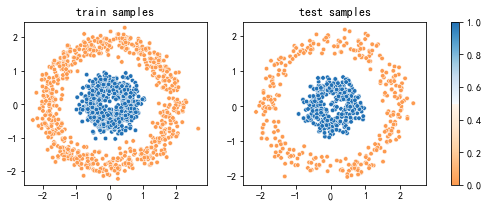

In [3]:
#可视化
fig = plt.figure(figsize = (9,3))
#自定义cmap
top = cm.get_cmap('Oranges_r', 512)
bottom = cm.get_cmap('Blues', 512)
newcolors = np.vstack((top(np.linspace(0.55, 1, 512)),
                       bottom(np.linspace(0, 0.75, 512))))
cm_bright = ListedColormap(newcolors, name='OrangeBlue')

plt.subplot(121)
m1 = plt.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
plt.title('train samples')
plt.axis('equal')
plt.subplot(122)
m2 = plt.scatter(*X_test.T,c = y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5);
plt.title('test samples')
plt.axis('equal')
ax = fig.get_axes()
plt.colorbar(ax = ax);
plt.show();

## 4. 进行训练并获得网络权重
`MLPClassifier((3,2),max_iter = 1000)`对网络进行构造，第一个参数指定了网络隐层的结构，默认为relu激活函数  
注意当某一隐层中有超过3节点时，可以进行编码，但是无法进行可视化

In [4]:
#分类
MLP = MLPClassifier((3,2),max_iter = 1000)
score = 0
while score < .98:    
    MLP.fit(X,y)
    score = MLP.score(X,y)
W,B = MLP.coefs_ , MLP.intercepts_
z = MLP.predict(p)
prob = MLP.predict_proba(p)[:,1];

## 5. 展示分类结果
注意底色颜色渐变的含义

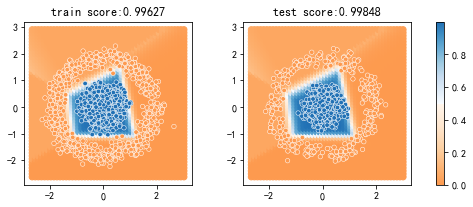

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9, 3),subplot_kw = {'aspect':'equal'})
ax1.scatter(*p.T,c = prob,cmap = cm_bright)
ax1.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax1.set_title('train score:%.5f'%MLP.score(X,y))
mp = ax2.scatter(*p.T,c = prob,cmap = cm_bright)
ax2.scatter(*X_test.T,c = y_test,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
ax2.set_title('test score:%.5f'%MLP.score(X_test,y_test));
plt.colorbar(mp,ax = [ax1,ax2]);

## 6. 定义相关工具函数
注意绘图函数的使用方法，结合本示例的调用方法进行调用即可


In [6]:

#'prism'
def scatter(p,c,X,wb = None,cmap = 'tab20'):
    cols = p.shape[-1]
    assert cols in (1,2,3)
    ax = plt.gca()
    dct = {}
    if c.dtype == 'float64':
        c_max,c_min = np.max(c),np.min(c)
        c_max_ = np.max(np.abs([c_max,c_min]))
        dct.update({'vmin' : -c_max_,'vmax':c_max_})
        if np.min(c) >= 0:
            dct.update({'edgecolors':'black','linewidths':0.05} )
    if cols == 3:        
        ax3d = ax
        if wb is not None:
            a1,a2 = p.min(0)[:2]
            b1,b2 = p.max(0)[:2]
            a,b = np.mgrid[a1 - 1:b1:10j,a2 - 1:b2:10j]
            (u1,u2,u3),b_ = wb
            z_ = (a * u1 + b * u2 + b_)/(-u3)
            ax3d.plot_wireframe(a, b, z_,colors = 'k')
        
        st = ax3d.scatter(*p.T,c = c,cmap=cmap,**dct)
        ax3d.scatter(*X.T,c = y,cmap = cm_bright,edgecolors='white',s = 40,linewidths = 0.5)
        #mp = ax3d.scatter(*p.T,c = c,cmap=cmap)
        #ax3d.set_xlabel('X')
        #ax3d.set_ylabel('Y')
        #ax3d.set_zlabel('Z')     
    elif cols == 2 :       
        ax.axis('equal')
        ax.axis('off')
        if wb is not None:
            a1,a2 = p.min(0) - 0.2
            b1,b2 = p.max(0) + 0.2
            (u1,u2),b_ = wb
            y1,y2 = (a1 * u1 +  b_)/(-u2),(b1 * u1 +  b_)/(-u2)           
            ax.plot([a1,b1],[y1,y2],'r--')            
            ax.set_ylim(a2,b2)
        st = ax.scatter(*p.T,c = c,cmap=cmap,**dct)   
        ax.scatter(*X.T,c = y,alpha = 0.7,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
        #ax.set_xlabel('X')
        #ax.set_ylabel('Y')
    else:
        t,tt = np.zeros_like(p.flat),np.zeros_like(X.flat)
        st = plt.scatter(p.flat,t,c = c,cmap=cmap,**dct)
        ax.scatter(X.flat,tt,c = y,alpha = 0.7,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)
    return st


def mapping(code):
    numMap= np.zeros(code.shape[0],'int')
    uniq = np.unique(code,axis = 0)
    for i,arr in enumerate(uniq):
        m = (np.sum(code == arr,axis = 1) == code.shape[-1])
        numMap[m] = i
    return numMap
...;

## 7. 各层及各节点可视化展示
说明：
* 从第二层开始，按照前向计算由浅层到深层的顺序，每层用两个图进行展示
* 每层展示的第一个图为该层各个节点的作用，第二个图展示该层整体的作用
* 在每层展示节点作用的图中，每行展示一个节点的情况（该层有多少节点就有多少行），其中每一行按从左向右的顺序分别展示：
    1. 对输入空间进行仿射变换
    2. 进行非线性变换
    3. 对输入空间进行划分
    4. 在原始特征空间进行划分
    5. 该节点划分与前面各隐层划分叠加

  共5个图
* 在展示第x层整体作用的图中，按照从左向右，从上到下的顺序分别展示的是：
    1. 第x层对输入空间的划分
    2. 第x层对原始特征空间的划分
    3. 对原始特征空间的划分
    4. 前x层激活神经元数量在原始特征空间中的分布
    5. 第x层的划分在该层空间的分布（非线性变换前),
    6. 第x层的划分在该层空间的分布（非线性变换后）
    7. 第x层的划分在该层空间的分布（非线性变换前后对比）
    8. 第x层激活神经元的数量在输入空间中的分布
    9. 输入空间进行仿射变换后在第x层空间中的情况
    10. 输入空间进行非线性变换后在第x层空间中的情况   
    
 共10个图

********************************************************************************************************************************************
第2层的情况如下
********************************************************************************************************************************************

第2层各节点的作用如下


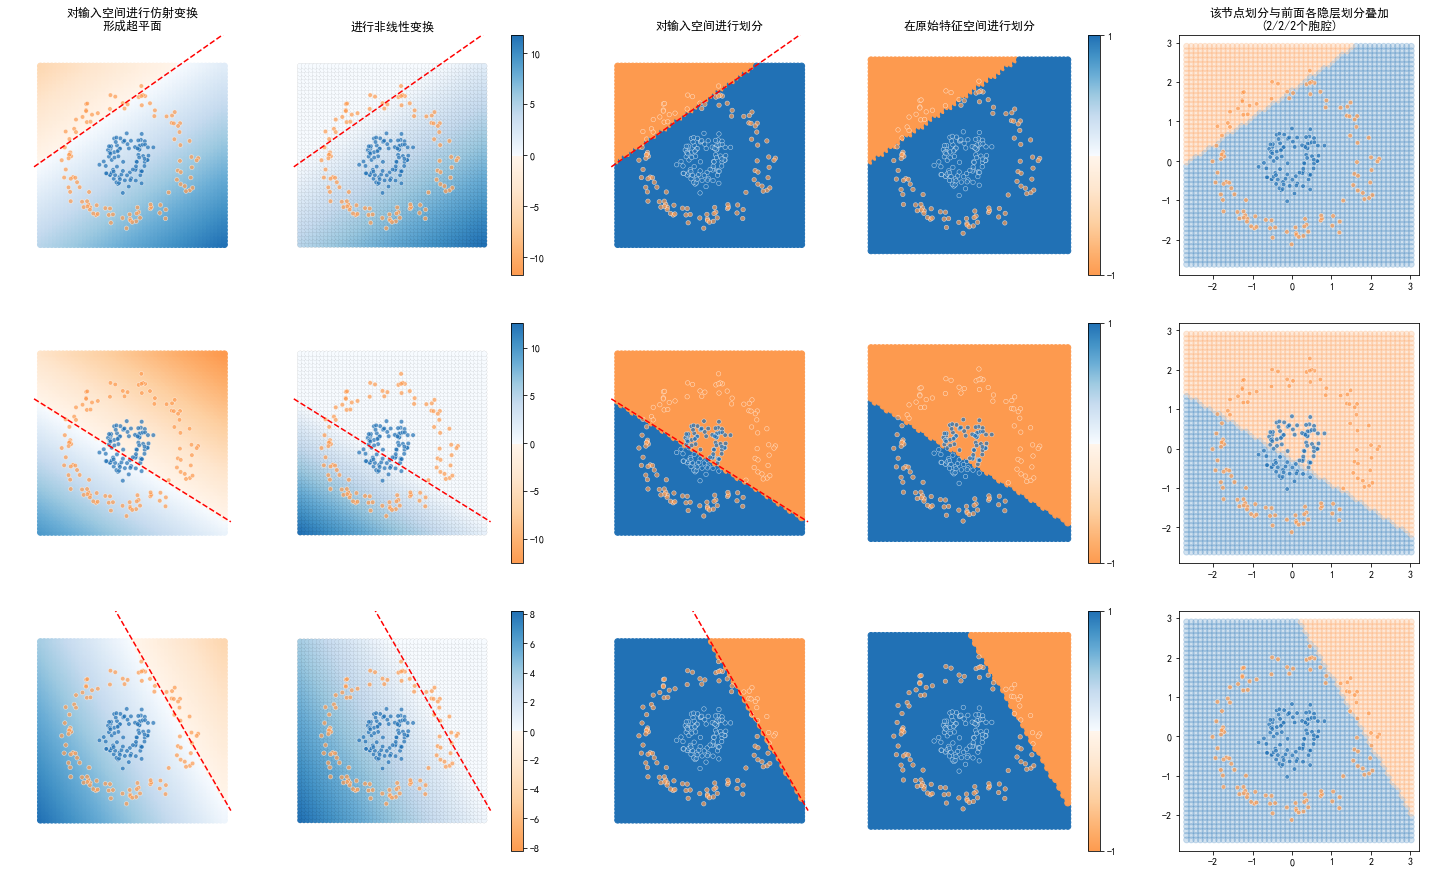


第2层整体的作用如下


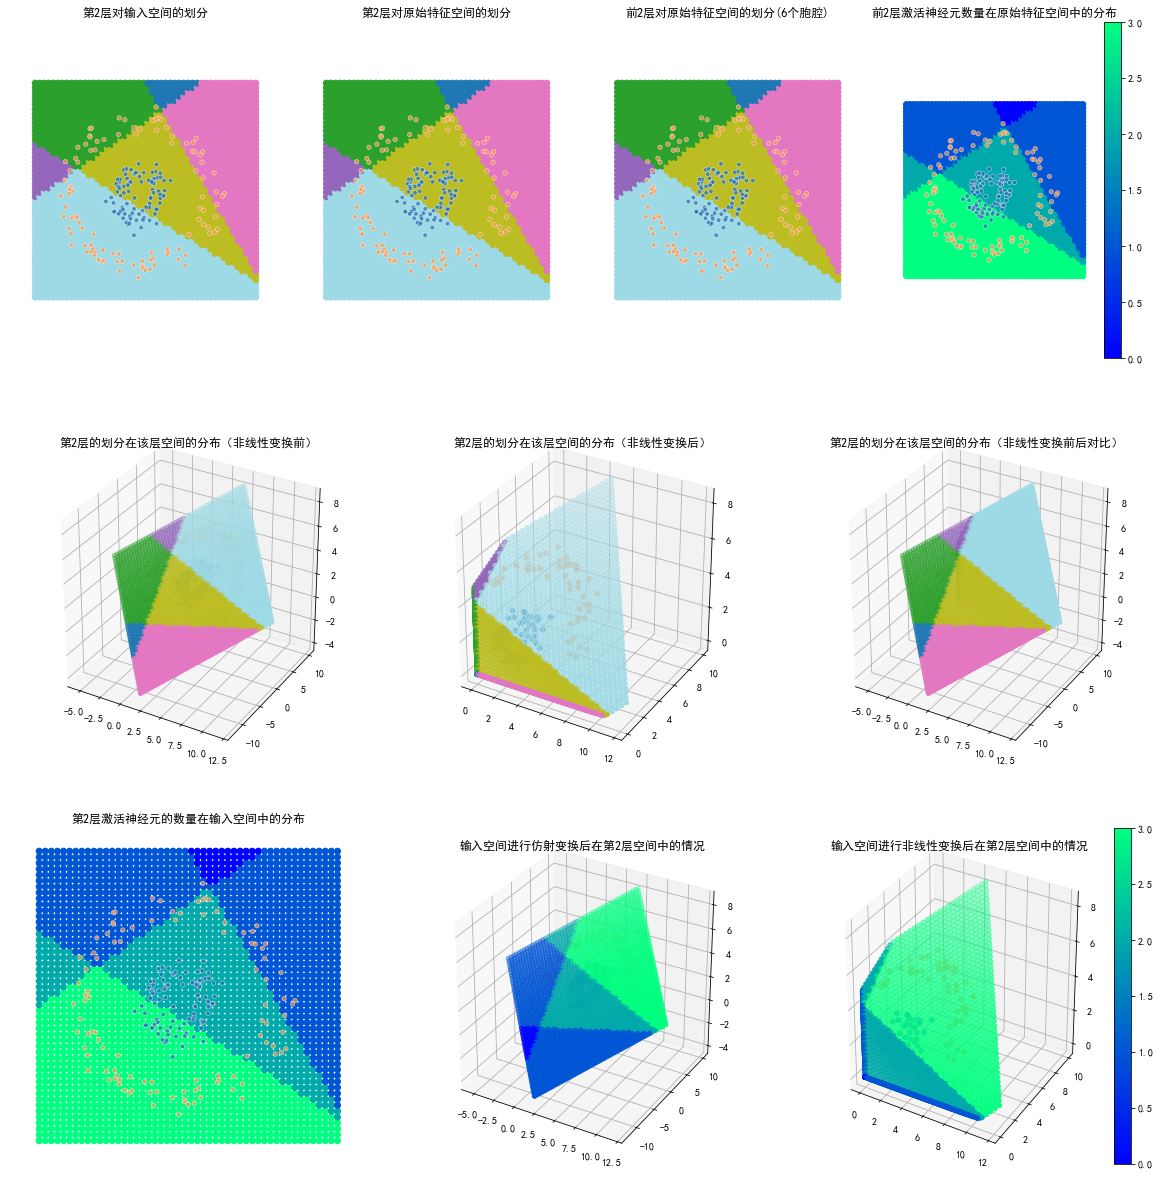





********************************************************************************************************************************************
第3层的情况如下
********************************************************************************************************************************************

第3层各节点的作用如下


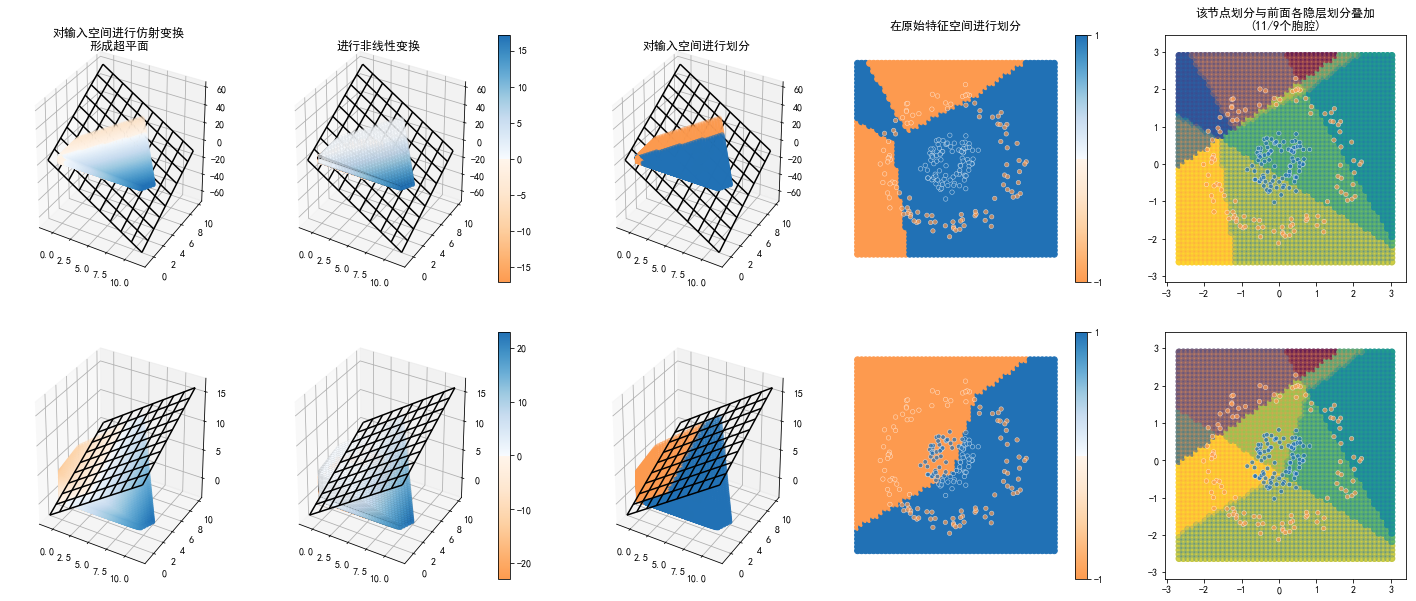


第3层整体的作用如下


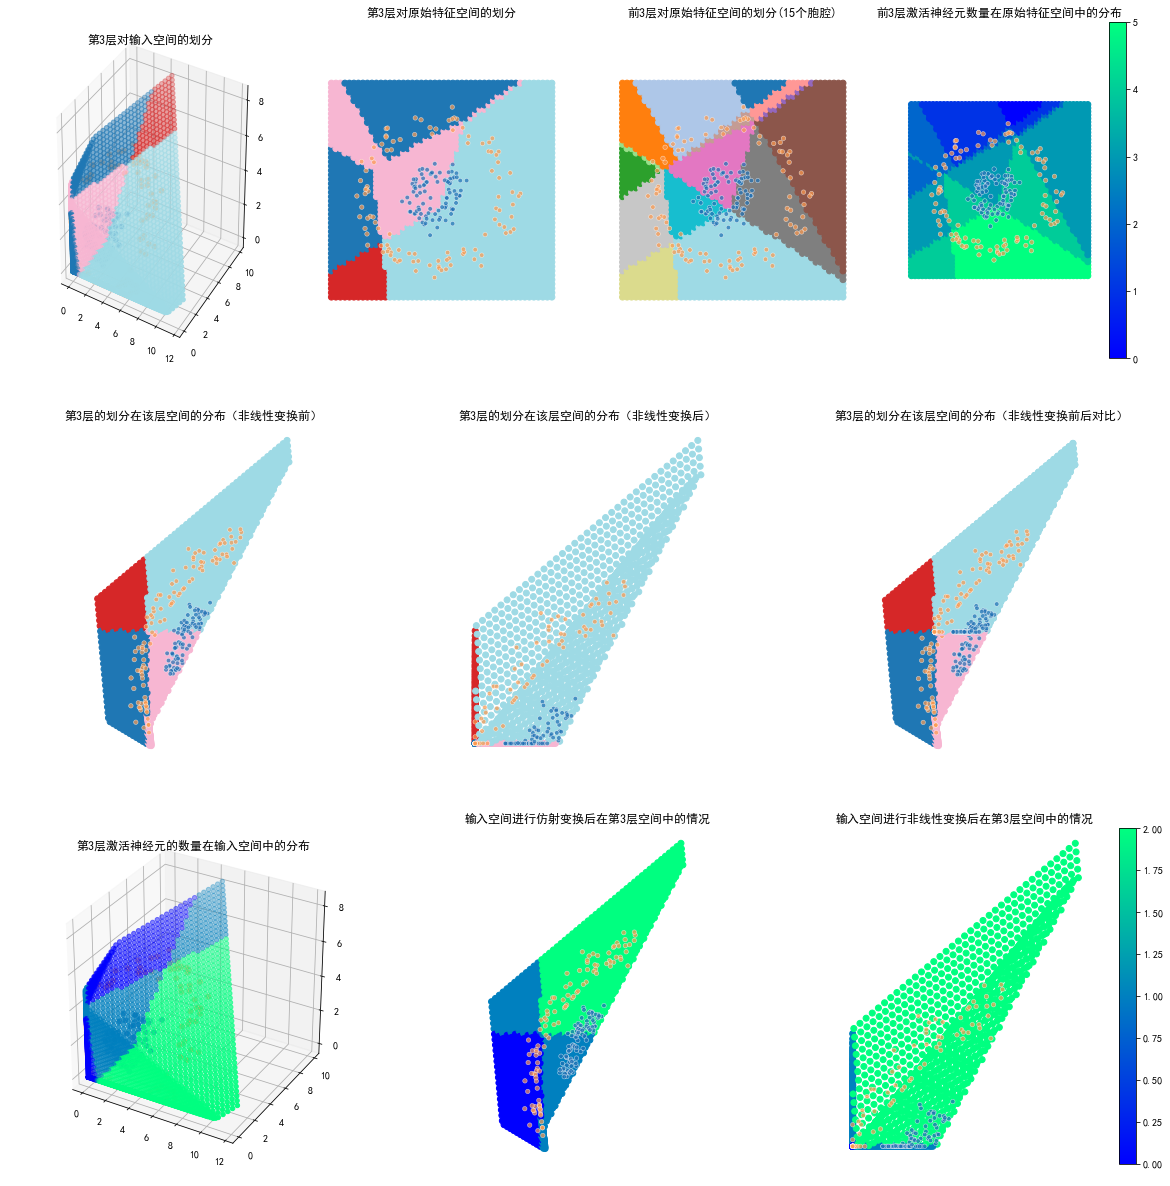





********************************************************************************************************************************************
第4层的情况如下
********************************************************************************************************************************************

第4层各节点的作用如下


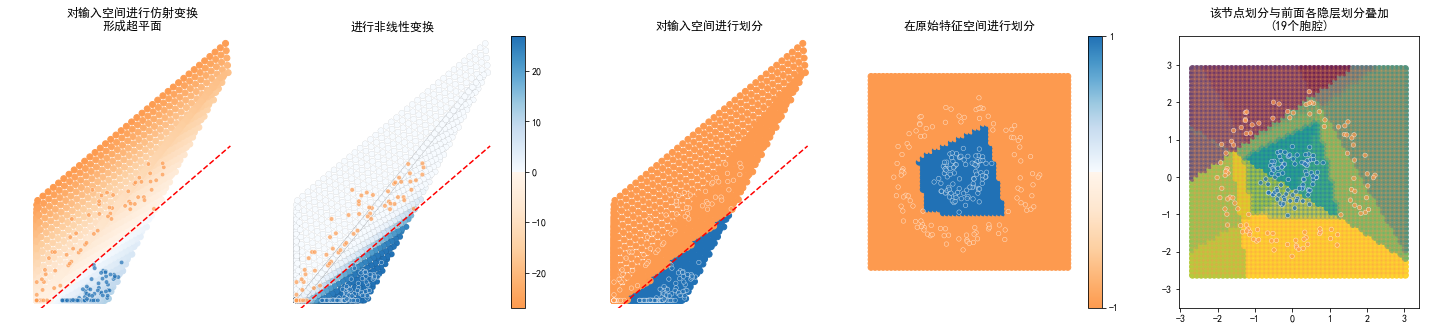


第4层整体的作用如下


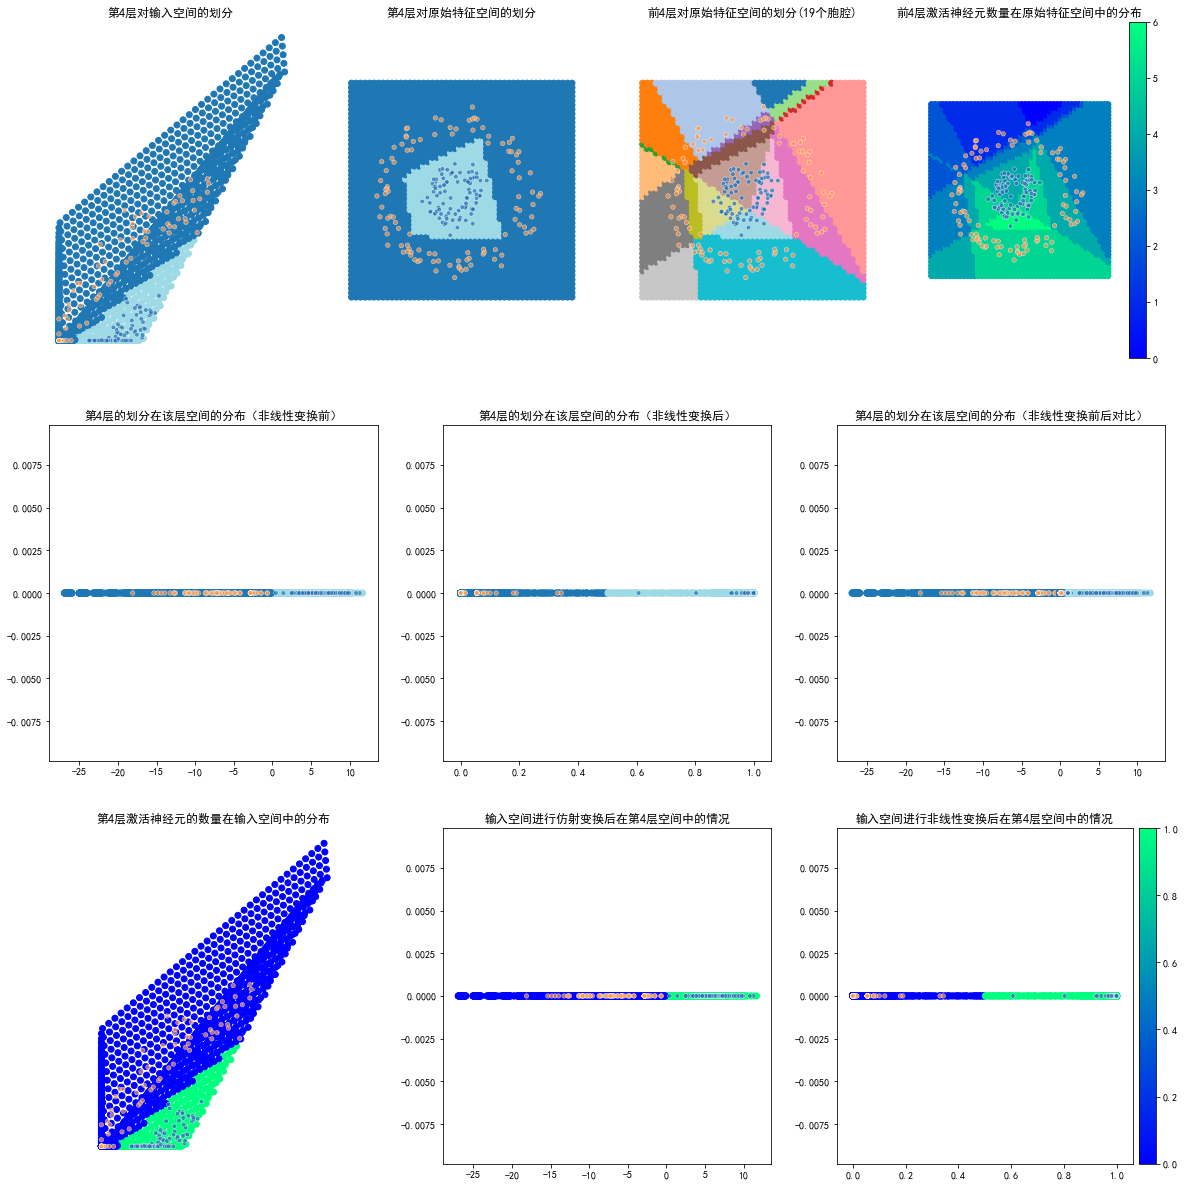

In [18]:
### 每个节点对应5个图：在输入空间形成超平面；输入空间进行非线性变换后的值；对输入空间进行划分；在原始特征空间进行划分；该节点与前n-1层的共同作用
### 每一层对应5个图：该层对输入空间的划分；该层对原始特征空间的划分；前n层对原始特征空间的划分；对输入空间进行仿射变换；进行非线性变换

#激活函数
actf = lambda x: np.where(x<0,0,x)
sigmoid = lambda x:1/(1+np.exp(-x))
threshold = 0
X = X[:200, :]
y = y[:200]
#plt.close('all')
inV, inX = p, X
layersBinCode = np.array([],'int').reshape(len(inV),-1)
nodesTitles = ['对输入空间进行仿射变换\n形成超平面','进行非线性变换','对输入空间进行划分','在原始特征空间进行划分','该节点划分与前面各隐层划分叠加']
layerTitles = ['第%s层对输入空间的划分','第%s层对原始特征空间的划分','前%s层对原始特征空间的划分','前%s层激活神经元数量在原始特征空间中的分布',
                '第%s层的划分在该层空间的分布（非线性变换前）','第%s层的划分在该层空间的分布（非线性变换后）','第%s层的划分在该层空间的分布（非线性变换前后对比）',
                '第%s层激活神经元的数量在输入空间中的分布', '输入空间进行仿射变换后在第%s层空间中的情况','输入空间进行非线性变换后在第%s层空间中的情况']

for s,(w, b) in enumerate(zip(W, B)):
    transV = inV @ w + b
    transX = inX @ w + b
    #第k层各个节点的划分(第k层的二进制编码)
    layerBinCode = np.where(transV > threshold, 1, 0)
    if b is B[-1]:
        actf = sigmoid
    actV = actf(transV)
    actX = actf(transX)
    n = actV.shape[-1] 

    #第k层的每个节点各自的划分与前k-1层的划分的叠加
    nodeNumCode = list(map(mapping,[np.hstack((layersBinCode,layerBinCode[:,i,None]))for i in range(n)]))
    preLNCode = None if s == 0 else layersNumCode
    #第k层的数字编码
    layerNumCode = mapping(layerBinCode)
    #第k层的激活神经元的数量
    layerNumCode2 = np.sum(layerBinCode, 1)    
    #前k层的二进制编码
    layersBinCode = np.hstack((layersBinCode, layerBinCode))   
    #前k层的数字编码
    layersNumCode = mapping(layersBinCode)
    #前k层激活神经元的数量
    layersNumCode2 = np.sum(layersBinCode, 1)


    l = np.vstack((w, b)).T.astype('<U5').tolist()
    sl = [';'.join(z) for z in l]
    projIn = '3d' if inV.shape[-1] == 3 else None
    projOut = '3d' if transV.shape[-1] == 3 else None
    fig = plt.figure(figsize=(5 * 5, n * 5))
    #fig.suptitle('第%s层各个节点的作用'%(s+2))
    print('*'*140)
    print(f'第{s+2}层的情况如下')
    print('*'*140)
    print(f'\n第{s+2}层各节点的作用如下')
    for i in range(n):
        axl,stl = [],[] 
        #在输入空间形成超平面
        axl += [plt.subplot(n,5,i * 5 + 1,projection = projIn)]
        stl += [scatter(inV, transV.T[i], inX, (w[:, i], b[i]), cmap=cm_bright)]
        #后层每个节点对输入空间进行激活的值
        axl += [plt.subplot(n,5,i * 5 + 2,projection = projIn)]
        stl += [scatter(inV, actV.T[i], inX, (w[:, i], b[i]), cmap=cm_bright)]        
        #后层每个节点对输入空间的划分
        t = np.where(layerBinCode.T[i] == 0,-1,1)
        axl += [plt.subplot(n,5,i * 5 + 3,projection = projIn)]
        stl += [scatter(inV, t, inX, (w[:, i], b[i]), cmap=cm_bright)]    
        #在原始特征空间进行划分
        axl += [plt.subplot(n,5,i * 5 + 4,projection = None)]
        stl += [scatter(p, t, X, cmap=cm_bright)]

        #该节点与前n-1层的共同作用
        axl += [plt.subplot(n,5,i * 5 + 5,projection = None)]
        axl[-1].axis('equal')
        if preLNCode is not None:
            stl += [axl[-1].scatter(*p.T,c = preLNCode)]
        axl[-1].scatter(*p.T,c = t,cmap=cm_bright,alpha = 0.2)
        axl[-1].scatter(*X.T,c = y,alpha = 0.7,cmap = cm_bright,edgecolors='white',s = 20,linewidths = 0.5)


        fig.colorbar(stl[0],ax = axl[:2],fraction = 0.08,pad = 0.02)
        fig.colorbar(stl[2],ax = axl[2:4],fraction = 0.08,pad = 0.02,ticks = [-1,1])

        #fig.colorbar(st3,ax = [ax],fraction = 0.08,pad = 0.02)
        #plt.tight_layout()
 
        if i == 0: 
            for ax,title in zip(axl,nodesTitles): 
                if title == nodesTitles[-1]:
                    num = '/'.join((np.max(nodeNumCode,1) + 1).astype('<U3'))
                    title += '\n(%s个胞腔)'%num
                ax.set_title(title)
    #plt.savefig(f"{s}.jpg")
    plt.show()
    print(f'\n第{s+2}层整体的作用如下')
    axl,stl = [],[]
    fig = plt.figure(figsize = (4*5,3*7))
    #fig.suptitle('第%s层的作用'%(s+2))
    #第k层对输入空间的总体划分（每个节点划分的叠加？）
    axl += [plt.subplot(341,projection = projIn)]
    stl += [scatter(inV, layerNumCode, inX)]
    #第k层对原始特征空间的总体划分（叠加？）
    axl += [plt.subplot(342,projection = None)]
    stl += [scatter(p, layerNumCode, X)]
    #前k层对原始特征空间胞腔分解情况(叠加？)
    axl += [plt.subplot(343,projection = None)]
    stl += [scatter(p, layersNumCode, X)]
    #fig.colorbar(st,ax = [ax1,ax2,ax3],fraction = 0.08,pad = 0.02)
    #前k层激活神经元数量在原始特征空间中的分布
    axl += [plt.subplot(344,projection = None)]
    stl += [scatter(p, layersNumCode2, X,cmap = 'winter')]

    #第k层的划分在第k层空间的分布（非线性变换前）
    axl += [plt.subplot(334,projection = projOut)]
    stl += [scatter(transV, layerNumCode, transX)]
    #第k层的划分在第k层空间的分布（非线性变换后）
    axl += [plt.subplot(335,projection = projOut)]
    stl += [scatter(actV, layerNumCode, actX)]
    #前两者画在同一个图中
    axl += [plt.subplot(336,projection = projOut)]
    stl += [scatter(transV, layerNumCode, transX)]
    scatter(actV, layerNumCode, actX)

    #第k层激活神经元的数量在输入空间中的分布
    axl += [plt.subplot(337,projection = projIn)]
    stl += [scatter(inV,layerNumCode2,inX,cmap = 'winter')]
    #输入空间进行仿射变换后在后层空间中的情况（第k层激活神经元的数量分布）
    axl += [plt.subplot(338,projection = projOut)]
    stl += [scatter(transV, layerNumCode2, transX, cmap='winter')]
    #输入空间在进行非线性变换后在后层空间中的情况（第k层激活神经元的数量分布）
    axl += [plt.subplot(339,projection = projOut)]
    stl += [scatter(actV, layerNumCode2, actX, cmap='winter')]

    fig.colorbar(stl[3],ax = axl[3])
    fig.colorbar(stl[-1],ax = axl[-1],fraction = 0.08,pad = 0.02)

    for ax,title in zip(axl,layerTitles):
        if title == layerTitles[2]: title += '(%s个胞腔)'%(np.max(layersNumCode) + 1)
        ax.set_title(title%(s+2))

    inX = actX
    inV = actV
    plt.show()
    print('\n'*3)
...;